In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

In [8]:
def get_dataset_path_and_labels(dataset_path):
    labels = []
    files = []
    for file in os.listdir(dataset_path):
        label = file.split('_')[-1].replace('.jpg','')
        labels.append(float(label))
        files.append(os.path.join(dataset_path, file))
    return files, labels

In [7]:
def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)

    # preprocess
    image = tf.image.resize(image, [256, 256])
    image /= 255.0 # normalize

    return image, label


In [9]:
def get_dataset(dataset_path):
    files, labels = get_dataset_path_and_labels(dataset_path)
    ds = tf.data.Dataset.from_tensor_slices((files, labels))
    ds = ds.map(load_and_preprocess_image)
    return ds

dataset = get_dataset('data/bicycles/')

In [16]:
x, y = next(dataset.take(1).as_numpy_iterator())

In [19]:
x.shape, y.shape

((256, 256, 3), ())

In [26]:
x, y

(array([[[0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843],
         ...,
         [0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843]],
 
        [[0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843],
         ...,
         [0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843]],
 
        [[0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843],
         ...,
         [0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843]],
 
        ...,
 
        [[0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607

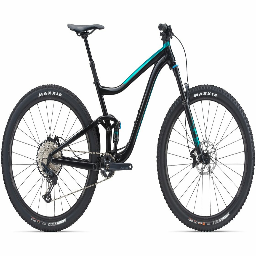

In [27]:
import PIL
# view x as image with PIL
PIL.Image.fromarray((x * 255).astype(np.uint8))

178/178 [==============================] - 318s 2s/step - loss: 14164283.0000 - mse: 14164283.0000


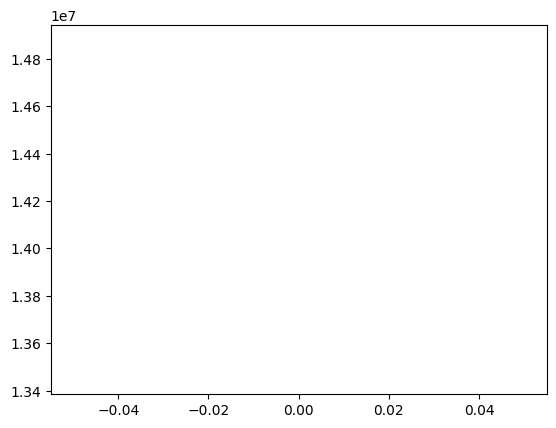

In [31]:
# create keras resnet 50 v2 model
base_model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet')

# freeze base model
base_model.trainable = False

# add regression head
inputs = tf.keras.Input(shape=(256, 256, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=['mse'])

# train model, specify batch size
history = model.fit(dataset.batch(32), epochs=1)

# plot history
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])

In [ ]:
# visualize part of the image which contributed most to the prediction
def visualize_heatmap(model, image):
    # get prediction
    prediction = model.predict(image[np.newaxis, ...])[0]
    # get gradient
    with tf.GradientTape() as tape:
        # cast image to float32
        inputs = tf.cast(image[np.newaxis, ...], tf.float32)
        # watch the input pixels
        tape.watch(inputs)
        # get the predictions
        predictions = model(inputs)
    # get the gradient of the loss with respect to the inputs
    gradients = tape.gradient(predictions, inputs)
    # get the mean gradient across the channels
    gradient = tf.reduce_mean(gradients, axis=(0, 3))
    # get the mean prediction across the channels
    prediction = tf.reduce_mean(predictions, axis=3)[0]
    # scale the prediction
    prediction /= tf.reduce_max(prediction)
    # scale the gradient
    gradient /= tf.reduce_max(gradient)
    # upsample the prediction and the gradient
    prediction = tf.image.resize(prediction, [256, 256])
    gradient = tf.image.resize(gradient, [256, 256])
    # convert to numpy
    prediction = prediction.numpy()
    gradient = gradient.numpy()
    # plot the prediction and the gradient
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.imshow(prediction, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.imshow(gradient, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.show()

